Para este exemplo, usamos o conjunto de dados providos pela Huawei

Usaremos as bibliotecas matemática padrão do Python (math) e a Numpy, além de Pandas para plotagem

In [25]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

Definição do conjunto de dados utilizado e o tipo de algoritmo,
seguido da impressão dos dados

In [26]:
algorithms = ["Classification", "Regression"]
algorithm = algorithms[0]

# Dataset1: Text features and text labels (golf.txt)
# Dataset2: Mix features and Numeric labels, here you have to change the path to yours.
datasets = ["arvoresDeDecisao/golf.txt", "arvoresDeDecisao/golf4.txt"]
dataset = pd.read_csv(datasets[0])  # (0,0), (0,1), (1,1)

dataset.head()

,Outlook,Temp.,Humidity,Wind,Decision
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes


Após isto, são verificados os tipos de dados, para identificar se serão tratados como valores discretos (rótulos) ou contínuos (números)

In [27]:
# This dictionary is used to store feature types of continuous numeric features and discrete literal features for subsequent judgment
dataset_features = dict()
num_of_columns = dataset.shape[1] - 1
#The data type of each column of the data is saved for displaying the data name
for i in range(0, num_of_columns):
    #Gets the column name and holds the characteristics of a column of data by column
    column_name = dataset.columns[i]
    #Save the type of the data
    dataset_features[column_name] = dataset[column_name].dtypes

dataset_features

{'Outlook': dtype('O'),
 'Temp.': dtype('O'),
 'Humidity': dtype('O'),
 'Wind': dtype('O')}

Checagem do tipo de dados e compatibilidade com algoritmo

In [28]:
# If the algorithm selects a regression tree but the label is not a continuous value, an error is
#reported
if algorithm == 'Regression':
    if dataset['Decision'].dtypes == 'object':
        raise ValueError('dataset wrong')
# If the tag value is continuous, the regression tree must be used
if dataset['Decision'].dtypes != 'object':
    algorithm = 'Regression'
    global_stdev = dataset['Decision'].std(ddof=0)

Processamento de atributos ou características contínuas.
É calculado a função de distribuição acumulada dos valores entrados,
e a frequência dos valores são divididas em duas partes,
maior ou menor igual que um limiar, que são utilizados como rótulos

In [29]:
# This function is used to handle numeric characteristics
def processContinuousFeatures(cdf, column_name):
    # Numerical features are arranged in order
    unique_values = sorted(cdf[column_name].unique())
    subset_ginis = []
    subset_red_stdevs = []
    for i in range(0, len(unique_values) - 1):
        threshold = unique_values[i]
        # Find the segmentation result if the first number is used as the threshold
        subset1 = cdf[cdf[column_name] <= threshold]
        subset2 = cdf[cdf[column_name] > threshold]
        # Calculate the proportion occupied by dividing the two parts
        subset1_rows = subset1.shape[0]
        subset2_rows = subset2.shape[0]
        total_instances = cdf.shape[0]
        # In the text feature part, entropy is calculated by using the cycle,
        # and in the numeric part, entropy is calculated by using the two groups after segmentation,
        # and the degree of entropy reduction is obtained
        if algorithm == 'Classification':
            decision_for_subset1, decision_for_subset2 = map(lambda x: x.value_counts.tolist(),
                                                             [subset1['Decision'], subset2['Decision']])
            gini_subset1, gini_subset2 = 1, 1
            for j in range(0, len(decision_for_subset1)):
                gini_subset1 = gini_subset1 - math.pow((decision_for_subset1[j] / subset1_rows), 2)
            for j in range(0, len(decision_for_subset2)):
                gini_subset2 = gini_subset2 - math.pow((decision_for_subset2[j] / subset2_rows), 2)
            gini = (subset1_rows / total_instances) * gini_subset1 + (subset2_rows / total_instances) * gini_subset2
            subset_ginis.append(gini)
            # Take standard deviation as the judgment basis, calculate the decrease value of standard deviation at this time
        elif algorithm == 'Regression':
            superset_stdev = cdf['Decision'].std(ddof=0)
            subset1_stdev = subset1['Decision'].std(ddof=0)
            subset2_stdev = subset2['Decision'].std(ddof=0)
            threshold_weighted_stdev = (subset1_rows / total_instances) * subset1_stdev + (
                    subset2_rows / total_instances) * subset2_stdev
            threshold_reducted_stdev = superset_stdev - threshold_weighted_stdev
            subset_red_stdevs.append(threshold_reducted_stdev)
    #Find the index of the split value
    if algorithm == "Classification":
        winner_one = subset_ginis.index(min(subset_ginis))
    elif algorithm == "Regression":
        winner_one = subset_red_stdevs.index(max(subset_red_stdevs))
    # Find the corresponding value according to the index
    winner_threshold = unique_values[winner_one]
    # Converts the original data column to an edited string column.
    # Characters smaller than the threshold are modified with the <= threshold value
    cdf[column_name] = np.where(cdf[column_name] <= winner_threshold, "<=" + str(winner_threshold),
                                ">" + str(winner_threshold))
    return cdf


dataset_clone = dataset.copy(deep=True)

try:
    processContinuousFeatures(dataset_clone, "Temp.")
    print("Before:\n", dataset.head())
    plt.hist(set(dataset["Temp."].values), density=True, range=(60, 90), bins=20)
    plt.ylabel("Density")
    plt.xlabel("Temperature [F]")
    print("\n\nAfter:\n", dataset_clone.head())
except:
    pass


Um dos meios de se identificar que atributos/features são mais relevantes para a decisão final é
o cálculo do ganho de informação, que se baseia na entropia dos dados.


Se temos um atributo composto de duas classes (e.g. a coluna 'Decision' pode assumir os valores 'Yes' e 'No),
a entropia deste atributo é dada pela seguinte fórmula

$p_{yes} = \frac{\#YesDecisions}{\#TotalDecisions}$

$p_{no} = \frac{\#NoDecisions}{\#TotalDecisions}$

$E(Decision) = - p_{yes} * log_2(p_{yes}) - p_{no}*log_2(p_{no})$

Quando calculamos para o dataset atual, encontramos:

In [30]:
# This function calculates the entropy of the column, and the input data must contain the Decision
# column
def calculateEntropy(dataset):
    # The regression tree entropy is 0
    if algorithm == 'Regression':
        return 0

    rows = dataset.shape[0]
    # Use Value_counts to get all values stored as dictionaries, keys: finds keys, and Tolist: change to lists.
    # This line of code finds the tag value.
    decisions = dataset['Decision'].value_counts().keys().tolist()
    entropy = 0
    # Here the loop traverses all the tags
    for i in range(0, len(decisions)):
        # Record the number of times the tag value appears
        num_of_decisions = dataset['Decision'].value_counts().tolist()[i]
        # probability of occurrence
        class_probability = num_of_decisions / rows
        # Calculate the entropy and sum it up
        entropy = entropy - class_probability * math.log(class_probability, 2)
    return entropy

if algorithm != 'Regression':
    entropy = calculateEntropy(dataset)
    print("E(Decision) = %f" % entropy)
else:
    print("Make sure to use Classification Algorithm and dataset golf.txt to print the entropy results")

E(Decision) = 0.940286


Para calcularmos o ganho de informação de cada coluna, precisamos calcular contribuição
das entropias de cada uma das classes/valores que um atributo/coluna pode assumir.


In [31]:
dataset.head()

,Outlook,Temp.,Humidity,Wind,Decision
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes



Por exemplo, para Outlook mostrado acima teremos:

$E(Sunny) = -\frac{0}{2}*log_{2}(\frac{0}{2})-\frac{2}{2}*log_{2}(\frac{2}{2})$\

$E(Rain) = -\frac{2}{2}*log_{2}(\frac{2}{2})-\frac{0}{2}*log_{2}(\frac{0}{2})$\

$E(Outcast) = -\frac{1}{1}*log_{2}(\frac{1}{1})-\frac{0}{1}*log_{2}(\frac{0}{1})$\

$Gain(Outlook) = E(Decision) - \frac{2}{5}*E(Sunny) - \frac{2}{5}*E(Rain) - \frac{1}{5}*E(Outcast)$\

In [32]:
def demo_gain_of_information(dataset=dataset[:5]):
    entropy = calculateEntropy(dataset)
    columns = dataset.shape[1]
    rows = dataset.shape[0]
    gains_of_information = {}
    # Traverse all columns and calculate the relevant indexes of all columns according to algorithm selection
    for i in range(0, columns-1):
        column_name = dataset.columns[i]
        column_type = dataset[column_name].dtypes
        classes = dataset[column_name].value_counts()
        class_gain_of_information = entropy
        # Start the loop with the type of data in the column
        for j in range(0, len(classes)):
            entropy_class = 0
            current_class = classes.keys().tolist()[j]
            # The final classification result corresponding to the data is selected
            # by deleting the value of the dataset column equal to the current data
            subdataset = dataset[dataset[column_name] == current_class]
            subset_instances = subdataset.shape[0]
            # The entropy of information is calculated here
            if algorithm == 'Classification':
                decision_list = subdataset['Decision'].value_counts().tolist()
                # Gain of Information
                # One of the possible scores to find out the most relevant column
                # Calculate for each decision (e.g. Decision==Yes and Decision==No) of a given class (e.g. Outlook==Sunny)
                for k in range(0, len(decision_list)):
                    p_decision = decision_list[k]/subset_instances
                    entropy_class -= math.log2(p_decision)*p_decision
                # After calculating the entropy for each decision,
                # we need to multiply by the frequency of the class (e.g. number of rows where Outlook==Sunny)
                # divided by the total instances of a class
                # (e.g. number of rows of Outlook, including Outlook==Sunny, Outlook==Rain, Outlook==Overcast)
                class_gain_of_information -= entropy_class*(subset_instances/rows)
            gains_of_information[column_name] = class_gain_of_information
    return gains_of_information



if algorithm != 'Regression':
    gains_of_information = demo_gain_of_information()
    print("Gains of information",*list(sorted(gains_of_information.items())), sep="\n")
else:
    print("Make sure to use Classification Algorithm and dataset golf.txt to print the entropy results")


Gains of information
('Humidity', 0.17095059445466854)
('Outlook', 0.9709505944546686)
('Temp.', 0.4199730940219749)
('Wind', 0.3219280948873623)


Executando as contas acima para cada um dos atributos/colunas, encontramos que o atributo
que contribui majoritariamente para a decisão final é a coluna de Outlook.

Existem outros métodos para esta escolha (estão implementados GINI para o caso de classificação, e desvio padrão para o caso de regressão).

In [33]:
# The main purpose of this function is to traverse the entire column of the table,
# find which column is the best split column, and return the name of the column
def findDecision(ddf):
    # If it's a regression tree, then you take the standard deviation of the true value
    if algorithm == 'Regression':
        stdev = ddf['Decision'].std(ddof=0)
    # Get the entropy of the decision column
    entropy = calculateEntropy(ddf)
    columns = ddf.shape[1]
    rows = ddf.shape[0]
    # Used to store Gini and standard deviation values
    ginis = []
    reducted_stdevs = []
    gains = []
    # Traverse all columns and calculate the relevant indexes of all columns according to algorithm selection
    for i in range(0, columns-1):
        column_name = ddf.columns[i]
        column_type = ddf[column_name].dtypes
        # Determine if the column feature is a number, and if so, process the data using the
        #following function, which modifies the data to a string type category on return.
        # The idea is to directly use character characteristics, continuous digital characteristics into
        #discrete character characteristics
        if column_type != 'object':
            ddf = processContinuousFeatures(ddf, column_name)
        # The statistical data in this column can be obtained, and the continuous data can be
        # directly classified after processing, and the categories are less than the threshold
        # and greater than the threshold
        classes = ddf[column_name].value_counts()
        gini = 0
        weighted_stdev = 0
        # Start the loop with the type of data in the column
        for j in range(0, len(classes)):
            gain = 0
            current_class = classes.keys().tolist()[j]
            # The final classification result corresponding to the data is selected
            # by deleting the value of the dataset column equal to the current data
            subdataset = ddf[ddf[column_name] == current_class]
            subset_instances = subdataset.shape[0]
            # The entropy of information is calculated here
            if algorithm == 'Classification':
                # GINI index
                # One of the possible scores to find out the most relevant column
                decision_list = subdataset['Decision'].value_counts().tolist()
                subgini = 1
                for k in range(0, len(decision_list)):
                    subgini = subgini - math.pow((decision_list[k] / subset_instances), 2)
                gini = gini + (subset_instances / rows) * subgini

                # Gain of Information
                # One of the possible scores to find out the most relevant column
                # Calculate for each decision (e.g. Decision==Yes and Decision==No) of a given class (e.g. Outlook==Sunny)
                for k in range(0, len(decision_list)):
                    p_decision = decision_list[k]/subset_instances
                    gain -= math.log2(p_decision)*p_decision
                # After calculating the entropy for each decision,
                # we need to multiply by the frequency of the class (e.g. number of rows where Outlook==Sunny)
                # divided by the total instances of a class
                # (e.g. number of rows of Outlook, including Outlook==Sunny, Outlook==Rain, Outlook==Overcast)
                gain *= (subset_instances/rows)

                # Then we subtract the calculated entropy from the total entropy to find the gain of information
                gain = entropy - gain
            # The regression tree is judged by the standard deviation,
            # and the standard deviation of the subclasses in this column is calculated here
            elif algorithm == 'Regression':
                subset_stdev = subdataset['Decision'].std(ddof=0)
                weighted_stdev = weighted_stdev + (subset_instances / rows) * subset_stdev
        # Used to store the final value of this column
        if algorithm == "Classification":
            ginis.append((i, gini))
            gains.append((i, gain))
            # Store the decrease in standard deviation for all columns
        elif algorithm == 'Regression':
            reducted_stdev = stdev - weighted_stdev
            reducted_stdevs.append(reducted_stdev)
            #print(column_name, current_class, reducted_stdev)
    # Determine which column is the first branch
    # by selecting the index of the largest value from the list of evaluation indicators
    if algorithm == "Classification":
        # You can choose whether to use GINI Index or Gain of Information here

        # Ginis is a list of tuples containing the largest contributor column and the contribution (lower number)
        min_ginis = list(sorted(ginis, key=lambda x: x[1]))[0]
        winner_index = min_ginis[0]  # get column

        # Gain of informations is a list of tuples containing the largest contributor column and the contribution (higher number)
        max_gain = list(sorted(gains, key=lambda x: x[1]))[-1]
        winner_index = max_gain[0]
    elif algorithm == "Regression":
        #print(reducted_stdevs)
        winner_index = reducted_stdevs.index(max(reducted_stdevs))
    winner_name = ddf.columns[winner_index]
    return winner_name


dataset_clone = dataset.copy(deep=True)
largest_contributor = findDecision(dataset_clone)
print("Largest contributor for the final decision:", largest_contributor)

Largest contributor for the final decision: Outlook


Podemos então começar a montar arvore de decisão recursivamente seguindo os passos:
 - encontrando o maior contribuidor
 - criando o nó para esse contribuidor
 - eliminando a coluna do maior contribuidor
 - montar a subarvore de decisão, desta vez sem a coluna do maior contribuidor

In [34]:
# With this function, you build the decision tree model,
# entering data in dataframe format, the indentation value, and the file address
# If the value in the column is literal, it branches directly by literal category
def buildDecisionTree(dataset, indentation=0):
    # Identify the different charForResp
    charForResp = "'"
    if algorithm == 'Regression':
        charForResp = ""
    tmp_indentation = indentation * 1
    dataset_copy = dataset.copy(deep=True)
    # Output the winning column of the decision tree, enter a list,
    # and output the column name of the decision column in the list
    winner_name = findDecision(dataset)
    # Determines whether the winning column is a number or a character
    numericColumn = False
    if dataset_features[winner_name] != 'object':
        numericColumn = True
    # To ensure the integrity of the original data and prevent the data from changing,
    # mainly to ensure that the data of other columns besides the winning column does not change,
    # so as to continue the branch in the next step.
    columns = dataset.shape[1]
    for i in range(0, columns - 1):
        column_name = dataset.columns[i]
        if dataset[column_name].dtype != 'object' and column_name != winner_name:
            dataset[column_name] = dataset_copy[column_name]
    # Find the element in the branching column
    classes = dataset[winner_name].value_counts().keys().tolist()
    # Traversing all classes in the branch column has two functions:
    # 1. Display which class is currently traversed to; 2. Determine whether the current class is
    #already leaf node
    for i in range(0, len(classes)):
        # Find the Subdataset as in FindDecision, but discard this column of the current branch
        current_class = classes[i]
        subdataset = dataset[dataset[winner_name] == current_class]
        # At the same time, the data of the first branch column is discarded and the remaining data
        #is processed
        subdataset = subdataset.drop(columns=[winner_name])
        # Edit the display situation. If it is a numeric feature, the character conversion has been
        #completed when searching for branches.
        #If it is not a character feature, it is displayed with column names
        if numericColumn == True:
            compareTo = current_class  # current class might be <=x or >x in this case
        else:
            compareTo = " == '" + str(current_class) + "'"

        terminateBuilding = False
        # -----------------------------------------------
        # This determines whether it is already the last leaf node
        if len(subdataset['Decision'].value_counts().tolist()) == 1:
            final_decision = subdataset['Decision'].value_counts().keys().tolist()[
                0]  # all items are equal in this case
            terminateBuilding = True
        # At this time, only the Decision column is left, that is, all the segmentation features havebeen used
        elif subdataset.shape[1] == 1:
            # get the most frequent one
            final_decision = subdataset['Decision'].value_counts().idxmax()
            terminateBuilding = True
        # The regression tree is judged as leaf node if the number of elements is less than 5
        #elif algorithm == 'Regression' and subdataset.shape[0] < 5: # pruning condition
        # Another criterion is to take the standard deviation as the criterion and the sample mean in
        #the node as the value of the node
        elif algorithm == 'Regression' and subdataset['Decision'].std(ddof=0) / global_stdev < 0.4:
            # get average
            final_decision = subdataset['Decision'].mean()
            terminateBuilding = True

        # indentation is a number used to generate ' ' to adjust the display format of the decision making process
        def formatRule(indentation):
            return '' + ' ' * indentation

        # -----------------------------------------------
        # Here we begin to output the branching results of the decision tree.。
        print(formatRule(indentation), "if ", winner_name, compareTo, ":")
        # -----------------------------------------------
        # check decision is made
        if terminateBuilding:
            print(formatRule(indentation + 1), "return ", charForResp + str(final_decision) + charForResp)
        else:  # decision is not made, continue to create branch and leafs
            # The size of the indent at display represented by indentation
            indentation = indentation + 1
            # Call this function again for the next loop
            buildDecisionTree(subdataset, indentation)
        indentation = tmp_indentation * 1


# call the function
buildDecisionTree(dataset)

 if  Outlook  == 'Sunny' :
  if  Humidity  == 'High' :
   return  'No'
  if  Humidity  == 'Normal' :
   return  'Yes'
 if  Outlook  == 'Rain' :
  if  Wind  == 'Weak' :
   return  'Yes'
  if  Wind  == 'Strong' :
   return  'No'
 if  Outlook  == 'Overcast' :
  return  'Yes'


Alteração do tipo de algoritmo e conjunto de dados, seguido da impressão dos dados

In [43]:
# Algoritmo "Regression"
algorithm = algorithms[1]

# Dataset2: Mix features and Numeric labels, here you have to change the path to yours.
# "arvoresDeDecisao/golf4.txt"
dataset = pd.read_csv(datasets[1])  # (0,0), (0,1), (1,1)

dataset.head()

,Outlook,Temp.,Humidity,Wind,Decision
0,Sunny,85,85,Weak,25
1,Sunny,80,90,Strong,30
2,Overcast,83,78,Weak,46
3,Rain,70,96,Weak,46
4,Rain,68,80,Weak,52


Verificar os tipos de dados, para identificar se serão tratados como valores discretos (rótulos) ou contínuos (números)

In [44]:
# This dictionary is used to store feature types of continuous numeric features and discrete literal features for subsequent judgment
dataset_features = dict()
num_of_columns = dataset.shape[1] - 1
#The data type of each column of the data is saved for displaying the data name
for i in range(0, num_of_columns):
    #Gets the column name and holds the characteristics of a column of data by column
    column_name = dataset.columns[i]
    #Save the type of the data
    dataset_features[column_name] = dataset[column_name].dtypes

dataset_features

{'Outlook': dtype('O'),
 'Temp.': dtype('int64'),
 'Humidity': dtype('int64'),
 'Wind': dtype('O')}

In [45]:
# If the algorithm selects a regression tree but the label is not a continuous value, an error is
#reported
if algorithm == 'Regression':
    if dataset['Decision'].dtypes == 'object':
        raise ValueError('dataset wrong')
# If the tag value is continuous, the regression tree must be used
if dataset['Decision'].dtypes != 'object':
    algorithm = 'Regression'
    global_stdev = dataset['Decision'].std(ddof=0)

Before:
     Outlook  Temp.  Humidity    Wind  Decision
0     Sunny     85        85    Weak        25
1     Sunny     80        90  Strong        30
2  Overcast     83        78    Weak        46
3      Rain     70        96    Weak        46
4      Rain     68        80    Weak        52


After:
     Outlook Temp.  Humidity    Wind  Decision
0     Sunny   >83        85    Weak        25
1     Sunny  <=83        90  Strong        30
2  Overcast  <=83        78    Weak        46
3      Rain  <=83        96    Weak        46
4      Rain  <=83        80    Weak        52


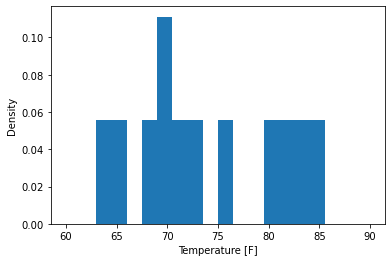

In [46]:
dataset_clone = dataset.copy(deep=True)

try:
    processContinuousFeatures(dataset_clone, "Temp.")
    print("Before:\n", dataset.head())
    plt.hist(set(dataset["Temp."].values), density=True, range=(60, 90), bins=20)
    plt.ylabel("Density")
    plt.xlabel("Temperature [F]")
    print("\n\nAfter:\n", dataset_clone.head())
except:
    pass

In [47]:
dataset_clone = dataset.copy(deep=True)
largest_contributor = findDecision(dataset_clone)
print("Largest contributor for the final decision:", largest_contributor)

Largest contributor for the final decision: Outlook


In [48]:
buildDecisionTree(dataset)

 if  Outlook  == 'Sunny' :
  if  Temp. <=83 :
   if  Wind  == 'Strong' :
    if  Humidity <=95 :
     return  30
   if  Wind  == 'Weak' :
    return  36.0
  if  Temp. >83 :
   return  25
 if  Outlook  == 'Rain' :
  if  Wind  == 'Weak' :
   return  48.0
  if  Wind  == 'Strong' :
   return  27.5
 if  Outlook  == 'Overcast' :
  return  45.75
